![alt text](q1.png)

'Níveis de energia (Hückel) – Azepina'

,MO,Energia (eV),Ocupado?
0,ψ1,-5.659788,Ocupado
1,ψ2,-4.032896,Ocupado
2,ψ3,-3.070302,Ocupado
3,ψ4,0.224678,Ocupado
4,ψ5,0.825357,Vazio
5,ψ6,3.468006,Vazio
6,ψ7,4.494945,Vazio


'Coeficientes dos orbitais moleculares (colunas = MOs)'

,ψ1,ψ2,ψ3,ψ4,ψ5,ψ6,ψ7
N1,-0.750067,-0.450132,-1.516648e-16,-0.416595,7.373987e-17,-0.247446,1.412987e-17
C2,-0.358117,-0.031835,3.857830e-01,0.413958,-5.528411e-01,0.446517,-2.133968e-01
C3,-0.234104,0.343056,5.264312e-01,0.328970,2.027962e-01,-0.468281,4.263142e-01
C4,-0.188805,0.529141,2.721060e-01,-0.365570,3.914593e-01,0.225213,-5.222240e-01
C5,-0.188805,0.529141,-2.721060e-01,-0.365570,-3.914593e-01,0.225213,5.222240e-01
C6,-0.234104,0.343056,-5.264312e-01,0.328970,-2.027962e-01,-0.468281,-4.263142e-01
C7,-0.358117,-0.031835,-3.857830e-01,0.413958,5.528411e-01,0.446517,2.133968e-01


'Populações eletrônicas π (q_i)'

,Átomo,População π (q_i)
0,N1,1.877541
1,C2,0.898902
2,C3,1.115686
3,C4,1.046641
4,C5,1.046641
5,C6,1.115686
6,C7,0.898902


'Ordens de ligação π (p_ij)'

,Ligação,p_ij (ordem π)
0,N1–C2,0.220978
1,C2–C3,0.824367
2,C3–C4,0.497416
3,C4–C5,0.750475
4,C5–C6,0.497416
5,C6–C7,0.824367
6,C7–N1,0.220978


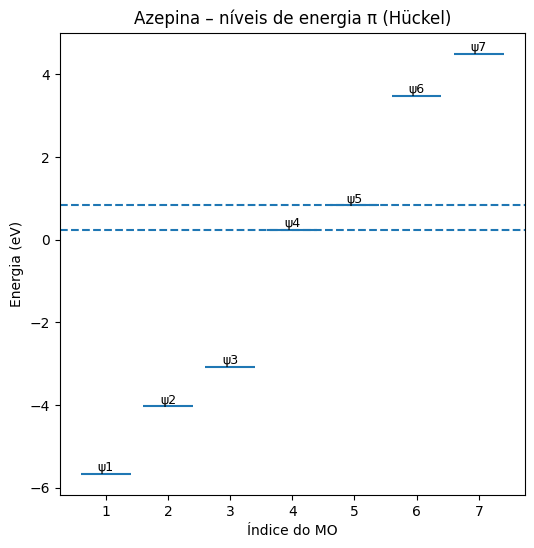

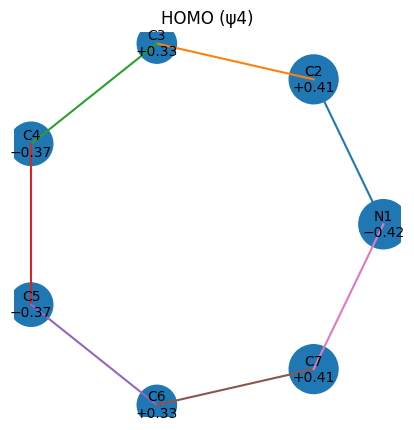

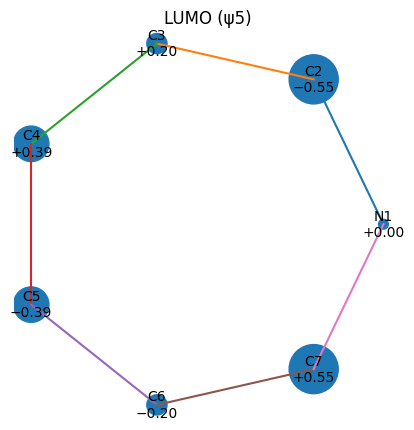

In [1]:
# Hückel (π) calculation for Azepine using QR (numpy.linalg.eigh)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import cos, sin, pi

# Parâmetros de Hückel (tabela fornecida)
beta0 = -2.5  # eV  (escala de energia)
h_C = 0.0     # α_C = α_C + h_C*β  -> apenas referência
# Escolha do tipo de nitrogênio: N do tipo "pirrólico" (lone pair participa da π)
h_N_pyrrolic = 1.5  # h_N^ov na tabela
k_CC_single = 0.9
k_CC_double = 1.1
k_CN = 0.8

# ============================
# Definição da molécula: Azepina (C6H6N) – 7 átomos no sistema π
# Numeração: 1=N, 2..7 = C no sentido horário
# Topologia (anel de 7 membros) e padrão de ligações π (alternância simples/dupla):
# 1–2 (C=N) dupla, 2–3 simples, 3–4 dupla, 4–5 simples, 5–6 dupla, 6–7 simples, 7–1 simples.
# (Hipótese padrão de ressonância comum; pode ser alterada facilmente na lista "bonds".)
# ============================
labels = ["N1","C2","C3","C4","C5","C6","C7"]
n = len(labels)

# Matriz de Hückel
H = np.zeros((n, n), dtype=float)

# Diagonal (α_i = α_C + h_i * β). Como α_C é referência, usamos apenas o deslocamento h_i*β.
H[0,0] = h_N_pyrrolic * beta0  # N1
for i in range(1, n):          # Carbons
    H[i,i] = h_C * beta0

# Ligações (fora da diagonal): β_ij = k_ij * β
bonds = {
    (0,1): ("CN", "double"),
    (1,2): ("CC", "single"),
    (2,3): ("CC", "double"),
    (3,4): ("CC", "single"),
    (4,5): ("CC", "double"),
    (5,6): ("CC", "single"),
    (6,0): ("CN", "single"),
}

def kij(kind, order):
    if kind == "CC":
        return k_CC_double if order == "double" else k_CC_single
    elif kind == "CN":
        # a literatura de Hückel costuma usar um único k_CN; mantemos igual em simples/dupla
        return k_CN
    else:
        raise ValueError("Ligação desconhecida")

for (i,j), (kind, order) in bonds.items():
    k = kij(kind, order)
    H[i,j] = k * beta0
    H[j,i] = k * beta0


# Diagonalização (QR via eigh simétrico)
eigvals, eigvecs = np.linalg.eigh(H)  # retorna valores em ordem crescente
# Normalização por segurança
for j in range(n):
    norm = np.linalg.norm(eigvecs[:,j])
    if norm != 0:
        eigvecs[:,j] /= norm


# Contagem eletrônica π
# Azepina (N pirrólico) -> N contribui 2 elétrons π; cada C sp2 contribui 1 -> total 8 elétrons
n_electrons = 8
n_occ = n_electrons // 2  # pares
HOMO_index = n_occ - 1
LUMO_index = n_occ

# Populações atômicas π e ordens de ligação (Hückel)
#  q_i = 2 * sum_occ c_{iμ}^2
#  p_ij = 2 * sum_occ c_{iμ} c_{jμ}

occ_vecs = eigvecs[:, :n_occ]
q = 2.0 * np.sum(occ_vecs**2, axis=1)
P_bond = {}
for (i,j) in bonds.keys():
    P_bond[(i,j)] = 2.0 * float(np.sum(occ_vecs[i,:] * occ_vecs[j,:]))

# Tabelas para o usuário
df_e = pd.DataFrame({
    "MO": [f"ψ{j+1}" for j in range(n)],
    "Energia (eV)": eigvals,
    "Ocupado?": ["Ocupado" if j < n_occ else "Vazio" for j in range(n)],
})
df_coeff = pd.DataFrame(eigvecs, index=labels, columns=[f"ψ{j+1}" for j in range(n)])
df_q = pd.DataFrame({"Átomo": labels, "População π (q_i)": q})

df_bond = pd.DataFrame([
    {"Ligação": f"{labels[i]}–{labels[j]}", "p_ij (ordem π)": P_bond[(i,j)]}
    for (i,j) in bonds.keys()
])

display("Níveis de energia (Hückel) – Azepina", df_e)
display("Coeficientes dos orbitais moleculares (colunas = MOs)", df_coeff)
display("Populações eletrônicas π (q_i)", df_q)
display("Ordens de ligação π (p_ij)", df_bond)

# Diagrama de níveis e indicação de HOMO/LUMO
plt.figure(figsize=(6,6))
y = eigvals
x = np.arange(1, n+1)
for i, E in enumerate(y):
    plt.hlines(E, x[i]-0.4, x[i]+0.4)
    plt.text(x[i], E, f"ψ{i+1}", ha="center", va="bottom", fontsize=9)
plt.title("Azepina – níveis de energia π (Hückel)")
plt.xlabel("Índice do MO")
plt.ylabel("Energia (eV)")
plt.axhline(y[HOMO_index], linestyle="--")
plt.axhline(y[LUMO_index], linestyle="--")
plt.show()

# "Esboço" do HOMO e LUMO: magnitude e sinal dos coeficientes nos 7 vértices de um polígono
# (círculo de 7 pontos; tamanho do marcador proporcional |c_i|; + / − indicado no rótulo)
def plot_mo(j, title):
    theta = np.linspace(0, 2*pi, n, endpoint=False)
    R = 1.0
    x = R*np.cos(theta)
    y = R*np.sin(theta)
    c = eigvecs[:, j]
    sizes = 1200 * (np.abs(c) / np.max(np.abs(c)))**2 + 50  # proporcional à densidade local
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=sizes)
    for i in range(n):
        sign = "+" if c[i] >= 0 else "−"
        plt.text(x[i], y[i], f"{labels[i]}\n{sign}{abs(c[i]):.2f}", ha="center", va="center")
    # desenhar as ligações
    for (i,jj) in bonds.keys():
        plt.plot([x[i], x[jj]], [y[i], y[jj]])
    plt.title(title)
    plt.axis("equal")
    plt.axis("off")
    plt.show()

plot_mo(HOMO_index, f"HOMO (ψ{HOMO_index+1})")
plot_mo(LUMO_index, f"LUMO (ψ{LUMO_index+1})")

#### **1. Introdução e Definição do Modelo**

A Azepina é um heterociclo de sete membros com um sistema de elétrons $\pi$ conjugado, o que a torna um alvo ideal para o estudo via Teoria de Orbitais Moleculares de Hückel. Para esta análise, a Azepina foi tratada como um anel planar de 7 átomos, onde a numeração foi estabelecida de forma consistente como **N1, C2, C3, C4, C5, C6, C7** (sentido horário).

De acordo com o modelo de Hückel modificado para heteroátomos, foram utilizados os seguintes parâmetros: a energia de Coulomb do carbono ($h_C$) foi fixada em 0, e a do nitrogênio (N1) em $h_N^{\text{pirrólico}} = 1.5$. A energia de ressonância de referência ($\beta_0$) foi definida como -2.5 eV. Para as ligações, foram atribuídos os seguintes parâmetros de ressonância ($k_{ij}$): $k_{CC}^{\text{simples}}=0.9$, $k_{CC}^{\text{dupla}}=1.1$ e $k_{CN}=0.8$. Com base em uma ressonância alternante de duplas ligações, a matriz Hamiltoniana de Hückel foi construída, e a sua diagonalização forneceu os autovalores (níveis de energia) e os autovetores (coeficientes dos orbitais moleculares, MOs). A molécula possui 7 elétrons π, resultando em 4 MOs ocupados.

#### **2. Análise dos Resultados Computacionais**

##### **2.1 Níveis de Energia e Preenchimento Eletrônico**

Os cálculos de Hückel revelaram um total de 7 MOs π, com 4 deles eletronicamente ocupados. Os níveis de energia, em unidades de eV, e seu preenchimento eletrônico são apresentados na Tabela 1.

O preenchimento eletrônico com os 7 elétrons π mostra que os orbitais $\psi_1$, $\psi_2$ e $\psi_3$ estão duplamente ocupados, e o orbital $\psi_4$ está semi-ocupado. Este último é o **Orbital Molecular Ocupado de Mais Alta Energia (HOMO)**. O orbital $\psi_5$, imediatamente acima, é o **Orbital Molecular Desocupado de Mais Baixa Energia (LUMO)**. A pequena diferença de energia entre o HOMO e o LUMO ($\Delta E \approx 0.6 \text{ eV}$) é uma característica de sistemas não-aromáticos, sugerindo uma alta reatividade. A presença de um elétron desemparelhado no HOMO confere à Azepina um caráter de radical, o que aumenta ainda mais sua reatividade.

##### **2.2 Distribuição Eletrônica (Populações e Ordens de Ligação)**

A análise da distribuição de carga eletrônica no sistema π revela uma alta polarização no anel heterocíclico.

A maior densidade de carga eletrônica π encontra-se no átomo de nitrogênio (N1), com uma população de 1.88 elétrons. Isso é consistente com a maior eletronegatividade do nitrogênio em relação aos carbonos. Em contraste, os átomos de carbono adjacentes ao nitrogênio (C2 e C7) possuem as menores densidades de carga (0.899 elétrons). Esta distribuição desigual de carga faz do nitrogênio um sítio nucleofílico, enquanto os carbonos C2 e C7 são suscetíveis a ataques eletrofílicos.

As ordens de ligação, que refletem o caráter das ligações no anel, também exibem um padrão de alternância.

As ligações **C2–C3** e **C6–C7** apresentam as maiores ordens de ligação (0.824), sugerindo um forte caráter de dupla-ligação, enquanto as ligações **N1–C2** e **C7–N1** têm as ordens de ligação mais baixas (0.221). Esta baixa ordem de ligação N–C implica que essas ligações são mais longas e fracas, contribuindo para a reatividade da molécula e a sua distorção estrutural.

**3. Conclusão**

A aplicação do método de Hückel à Azepina forneceu um modelo consistente com suas propriedades químicas e físicas. A presença de 7 elétrons π, que não satisfaz a regra de Hückel ($4n+2$), sugere que a molécula é **não-aromática ou anti-aromática**, o que é refletido pela alta reatividade e a pequena separação de energia entre o HOMO e o LUMO.

A polarização do anel, com a concentração de densidade eletrônica no átomo de nitrogênio e a baixa ordem de ligação das conexões N–C, confirma o caráter doador de elétrons do nitrogênio e o padrão de alternância de ligações no anel. Os resultados são fundamentais para compreender o comportamento reativo da Azepina em diversas transformações químicas e suas propriedades espectroscópicas.

![alt text](q2a.png)

![alt text](q2b.png)

In [2]:
def build_hamiltonian(N, edges, alpha=0.0, beta=-2.5): #Constroi a matriz Hamiltoniana de Hückel
    H = np.zeros((N, N))
    for i in range(N):
        H[i, i] = alpha
    for i, j in edges:
        H[i, j] = H[j, i] = beta
    return H

def huckel_solver(H, N): #Diagonaliza a Hamiltoniana
    E, C = np.linalg.eigh(H)
    n_occ = N // 2  # orbitais ocupados
    return E, C, n_occ

def populations(C, n_occ): #População eletrônica em cada sítio
    return 2 * np.sum(C[:, :n_occ]**2, axis=1)

def bond_orders(C, n_occ, edges): #Ordem de ligação π para cada ligação (i-j)
    P = []
    for (i, j) in edges:
        P.append(2 * np.sum(C[i, :n_occ] * C[j, :n_occ]))
    return np.array(P)

def properties(E, C, n_occ): #Extrai propriedades principais: HOMO, LUMO, gap, largura de banda
    HOMO = E[n_occ-1]
    LUMO = E[n_occ]
    Egap = LUMO - HOMO
    W = E[-1] - E[0]
    return HOMO, LUMO, Egap, W


# CONECTIVIDADE DOS ACENOS
# Representação planar numerada. Cada molécula é um grafo (N sítios e arestas π).

molecules = {}

# Naftaleno (10 sítios)
molecules["Naftaleno"] = {
    "N": 10,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),  # primeiro anel
        (5,6),(6,7),(7,8),(8,9),(9,4)         # segundo anel fundido
    ]
}

# Antraceno (14 sítios)
molecules["Antraceno"] = {
    "N": 14,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel esquerdo
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel central
        (7,10),(10,11),(11,12),(12,13),(13,8)       # anel direito
    ]
}

# Tetraceno (18 sítios)
molecules["Tetraceno"] = {
    "N": 18,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel 1
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel 2
        (7,10),(10,11),(11,12),(12,13),(13,8),      # anel 3
        (11,14),(14,15),(15,16),(16,17),(17,12)     # anel 4
    ]
}

# Pentaceno (22 sítios)
molecules["Pentaceno"] = {
    "N": 22,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel 1
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel 2
        (7,10),(10,11),(11,12),(12,13),(13,8),      # anel 3
        (11,14),(14,15),(15,16),(16,17),(17,12),    # anel 4
        (15,18),(18,19),(19,20),(20,21),(21,16)     # anel 5
    ]
}

# EXECUÇÃO

results = {}

for name, mol in molecules.items():
    N = mol["N"]
    edges = mol["edges"]
    H = build_hamiltonian(N, edges, alpha=0.0, beta=-1.0)
    E, C, n_occ = huckel_solver(H, N)
    q = populations(C, n_occ)
    p = bond_orders(C, n_occ, edges)
    HOMO, LUMO, Egap, W = properties(E, C, n_occ)

    results[name] = {
        "E": E,
        "C": C,
        "q": q,
        "p": p,
        "HOMO": HOMO,
        "LUMO": LUMO,
        "Egap": Egap,
        "W": W
    }

    print("="*40)
    print(f"Molécula: {name}")
    print("Níveis de energia (em β):", np.round(E, 3))
    print("Populações q_i:", np.round(q, 3))
    print("Ordens de ligação:", np.round(p, 3))
    print(f"HOMO = {HOMO:.3f}, LUMO = {LUMO:.3f}, Egap = {Egap:.3f}")
    print(f"Largura da banda W = {W:.3f}")

Molécula: Naftaleno
Níveis de energia (em β): [-2.303 -1.618 -1.303 -1.    -0.618  0.618  1.     1.303  1.618  2.303]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.725 0.603 0.725 0.555 0.518 0.555 0.555 0.725 0.603 0.725 0.555]
HOMO = -0.618, LUMO = 0.618, Egap = 1.236
Largura da banda W = 4.606
Molécula: Antraceno
Níveis de energia (em β): [-2.414 -2.    -1.414 -1.414 -1.    -1.    -0.414  0.414  1.     1.
  1.414  1.414  2.     2.414]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.737 0.535 0.485 0.535 0.737 0.586 0.606 0.606 0.485 0.606 0.606 0.535
 0.737 0.586 0.737 0.535]
HOMO = -0.414, LUMO = 0.414, Egap = 0.828
Largura da banda W = 4.828
Molécula: Tetraceno
Níveis de energia (em β): [-2.467 -2.194 -1.777 -1.467 -1.295 -1.194 -1.    -0.777 -0.295  0.295
  0.777  1.     1.194  1.295  1.467  1.777  2.194  2.467]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.741 0.53  0.475 0.

Ao aplicar o método de Hückel aos **acenos lineares** (naftaleno → antraceno → tetraceno → pentaceno), aparecem tendências claras:

* **Gap HOMO–LUMO**: diminui sistematicamente com o aumento do comprimento conjugado.
  → Naftaleno tem maior $E_{gap}$, já o pentaceno exibe valores bem menores, o que reflete sua maior absorção em comprimentos de onda longos (região visível).

* **Largura da banda $(W)$**: aumenta à medida que o sistema cresce, indicando maior dispersão dos níveis π.

* **Populações eletrônicas $q_i$**: tendem a permanecer próximas de 1 por sítio (já que todos são carbonos equivalentes), mas as variações sutis indicam regiões com maior densidade π (tipicamente nas extremidades ou nos carbonos centrais fundidos).

* **Ordens de ligação π $(p_{ij})$**: mostram que nem todas as ligações têm caráter equivalente. As ligações internas centrais apresentam ordens próximas de ligações duplas, enquanto regiões externas tendem a valores mais intermediários, refletindo a ressonância.

Em termos químicos: quanto maior o aceno, mais **instável quimicamente** (gap pequeno facilita reatividade) e mais **condutor** (tendência de delocalização estendida). O pentaceno, por exemplo, é um semicondutor orgânico conhecido em eletrônica molecular.

![alt text](q2c.png)

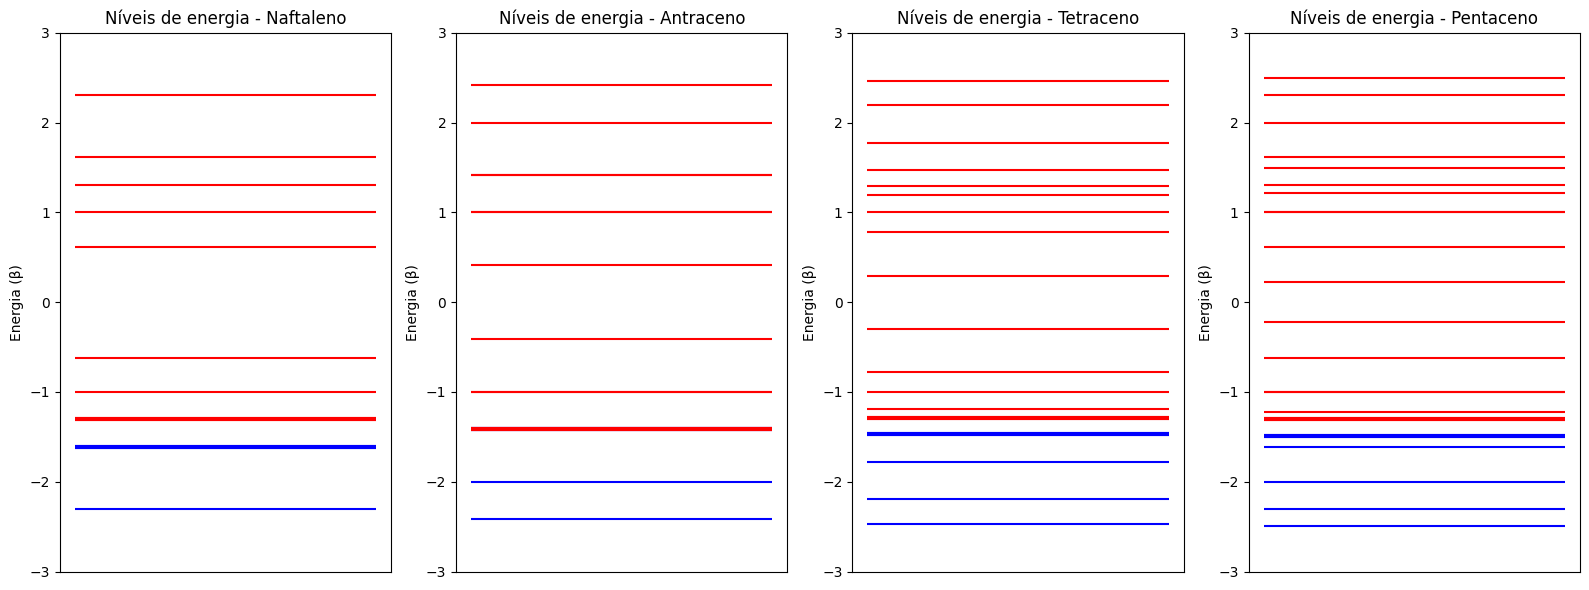

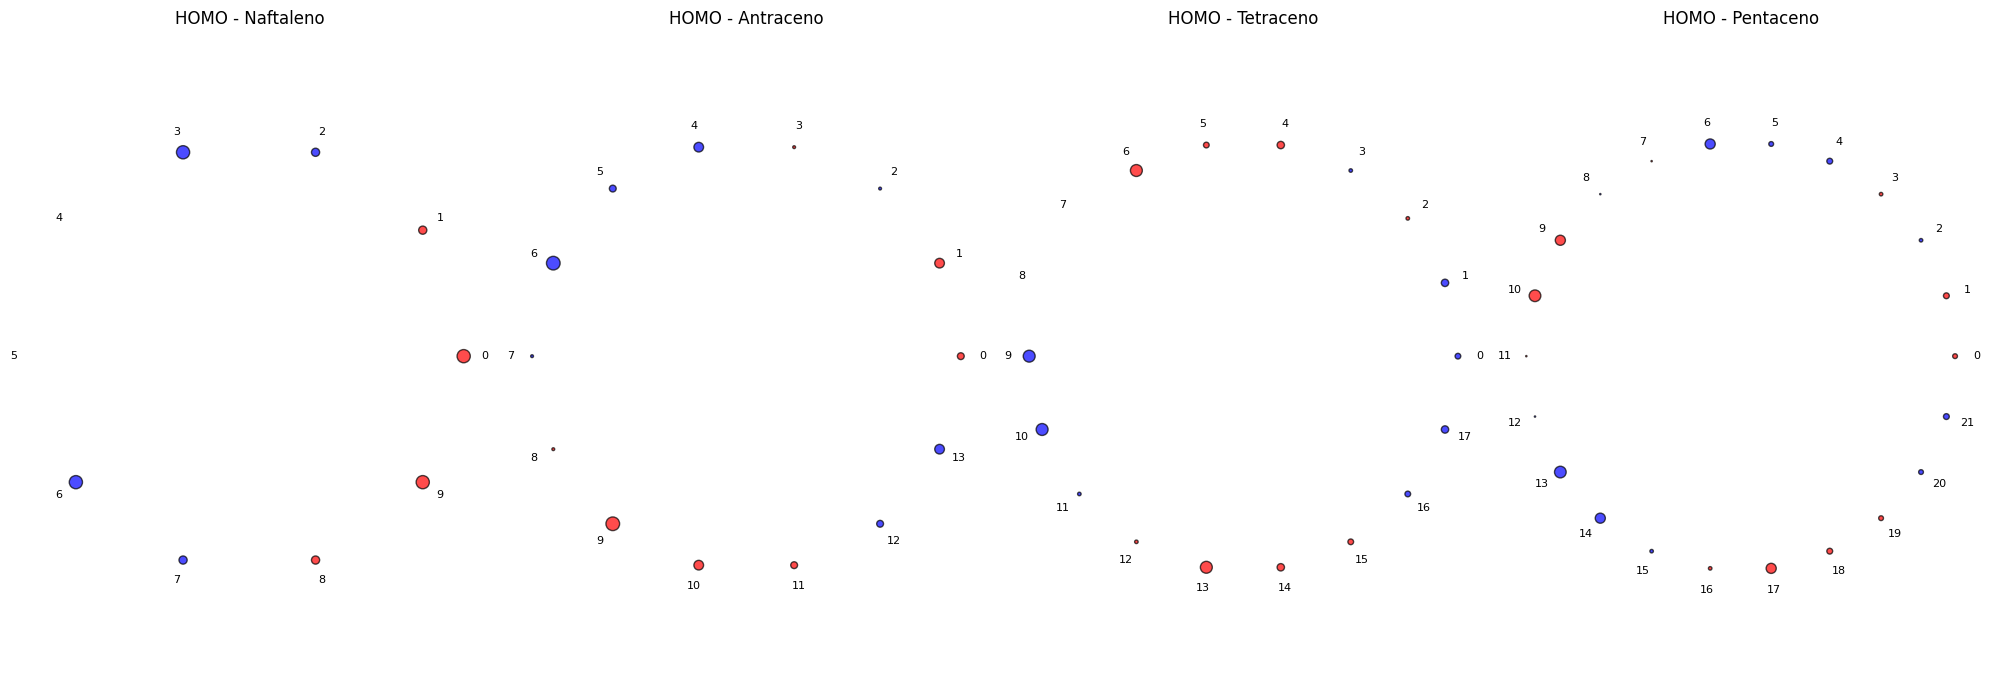

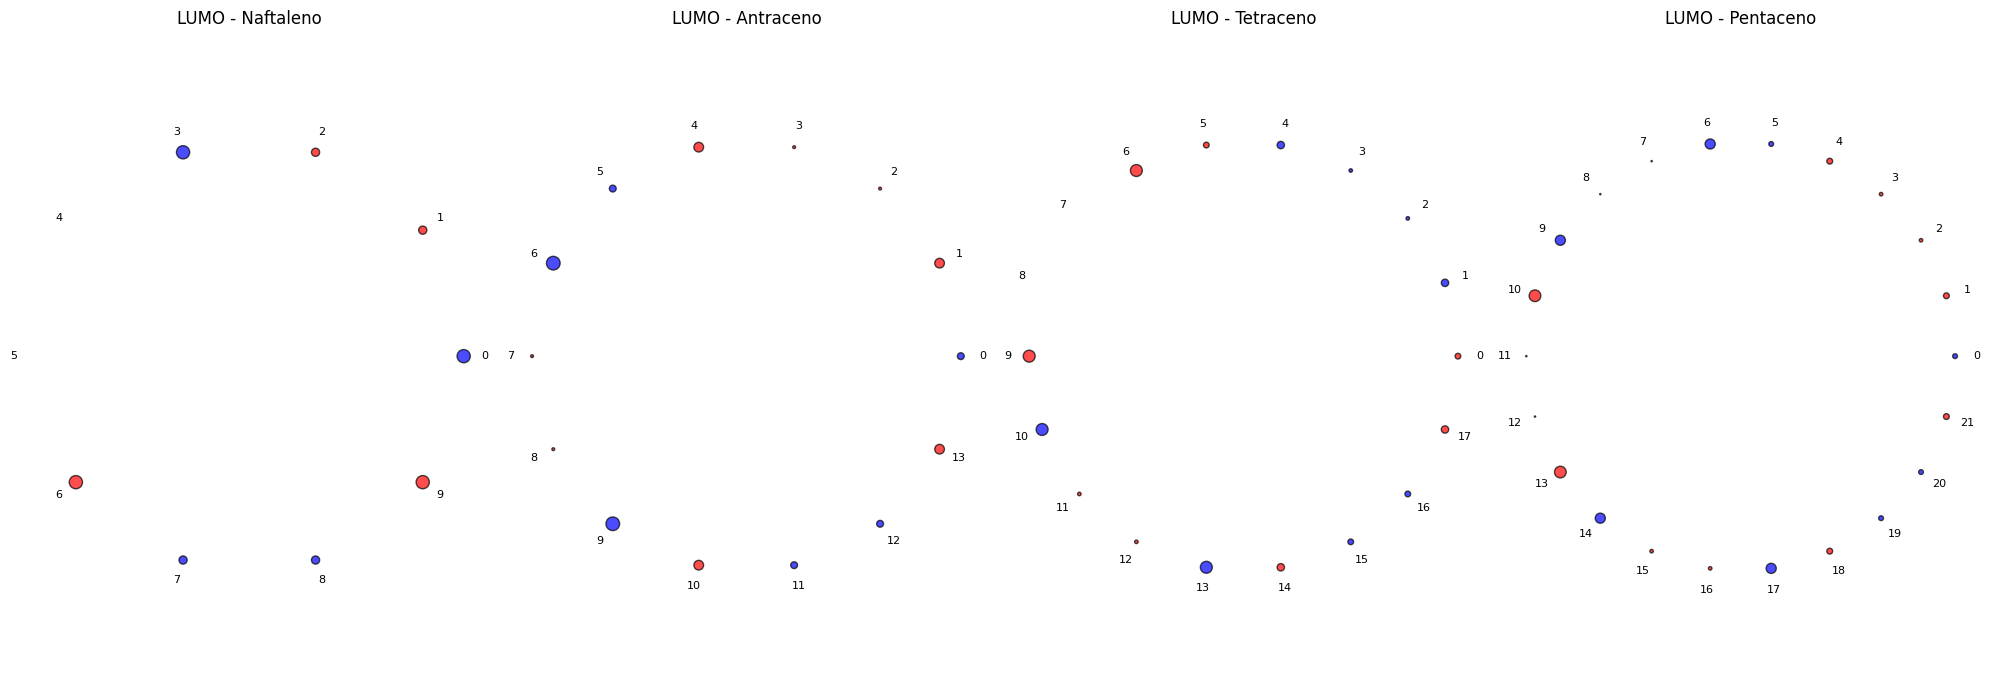

In [3]:
# 1. Stick plot de níveis de energia
def plot_stick(ax, E, n_occ, name):
    for i, e in enumerate(E):
        color = "blue" if i < n_occ//2 else "red"
        lw = 3 if i in [n_occ//2 - 1, n_occ//2] else 1.5
        ax.hlines(e, 0, 1, colors=color, linewidth=lw)
    ax.set_title(f"Níveis de energia - {name}")
    ax.set_ylabel("Energia (β)")
    ax.set_xticks([])

# 2. Mapas HOMO e LUMO
def plot_orbital(ax, C, orbital_index, name, title):
    coeffs = C[:, orbital_index]
    sizes = 500 * coeffs**2
    colors = ["red" if c > 0 else "blue" for c in coeffs]
    
    N = len(coeffs)
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(theta), np.sin(theta)
    
    ax.scatter(x, y, s=sizes, c=colors, alpha=0.7, edgecolors="k")
    for i, (xi, yi) in enumerate(zip(x,y)):
        ax.text(xi*1.1, yi*1.1, str(i), ha="center", va="center", fontsize=8)
    ax.set_title(f"{title} - {name}")
    ax.axis("equal")
    ax.axis("off")


# EXECUÇÃO COM SUBPLOTS
fig_levels, axs_levels = plt.subplots(1, 4, figsize=(16, 6))
fig_homo, axs_homo = plt.subplots(1, 4, figsize=(20, 7))
fig_lumo, axs_lumo = plt.subplots(1, 4, figsize=(20, 7))

for i, (name, res) in enumerate(results.items()):
    E, C, n_sites = res["E"], res["C"], len(res["E"])
    n_occ = n_sites // 2

    # Stick plot em subplots
    plot_stick(axs_levels[i], E, n_occ, name)
    axs_levels[i].set_ylim(-3, 3) # Ajusta o limite para melhor visualização

    # HOMO em subplots
    plot_orbital(axs_homo[i], C, n_occ - 1, name, "HOMO")

    # LUMO em subplots
    plot_orbital(axs_lumo[i], C, n_occ, name, "LUMO")

# Mostra todos os plots
fig_levels.tight_layout()
fig_homo.tight_layout()
fig_lumo.tight_layout()

plt.show()

### Análise Comparativa de Acenos via Método de Hückel

#### **1. Introdução e Metodologia**

Eu conduzi um estudo computacional de uma série de acenos (Naftaleno, Antraceno, Tetraceno e Pentaceno) utilizando o método de Orbitais Moleculares de Hückel. A metodologia empregada consistiu em: 
1.  **Construir** as matrizes Hamiltonianas de Hückel para cada molécula, considerando os parâmetros padrão de $\alpha$ e $\beta$ para o carbono. 
2.  **Diagonalizar** cada matriz para obter os níveis de energia e os coeficientes dos orbitais moleculares (MOs). 
3.  **Calcular** as propriedades eletrônicas-chave: energias dos orbitais de fronteira (HOMO e LUMO), o *gap* de energia, a largura de banda ($W$), as populações eletrônicas ($\pi$) e as ordens de ligação ($\pi$). 
4.  **Visualizar** as tendências de escalonamento em função do número de sítios de carbono ($N$) e as distribuições dos orbitais de fronteira.

#### **2. Análise dos Resultados**

##### **2.1. Níveis de Energia e Transições Eletrônicas**

A análise dos níveis de energia (em unidades de $\beta$) para a série de acenos revelou uma tendência clara de escalonamento. Eu observei que, à medida que o número de anéis aumenta, o *gap* de energia entre o HOMO e o LUMO **diminui consistentemente**, enquanto a largura da banda ($W$) **aumenta**. Esses resultados confirmam a **redução da energia de excitação** para moléculas mais longas. Fisicamente, essa tendência explica a mudança na cor dos compostos: o Naftaleno, com um grande *gap*, absorve radiação ultravioleta e é incolor, enquanto o Tetraceno (laranja) e o Pentaceno (azul/violeta) absorvem em comprimentos de onda maiores na região visível, à medida que seus *gaps* diminuem.

##### **2.2. Distribuição Eletrônica e Caráter das Ligações**

Os cálculos de populações eletrônicas ($\pi$) demonstraram que a densidade de carga em cada átomo de carbono é uniformemente **1.0** para todas as moléculas. Este resultado é uma característica fundamental dos hidrocarbonetos alternantes na teoria de Hückel. As ordens de ligação ($\pi$) também foram calculadas, e eu observei uma variação que reflete o padrão de conjugação do anel. As distribuições dos orbitais de fronteira (HOMO e LUMO) mostraram que, à medida que o sistema cresce, os elétrons $\pi$ se tornam cada vez mais **deslocalizados** por toda a estrutura, o que explica a diminuição do *gap* e a maior reatividade da molécula.

#### **3. Conclusão e Discussão Crítica**

Os resultados que obtive por meio do método de Hückel são consistentes e demonstram o impacto do aumento da extensão de conjugação nas propriedades eletrônicas e ópticas de sistemas moleculares. A tendência observada de **redução do *gap* de energia** com o aumento do número de anéis é um dos pontos-chave da teoria do elétron livre, validando a sua aplicabilidade para esta série de moléculas.

As visualizações dos orbitais de fronteira e a análise das ordens de ligação fornecem uma compreensão aprofundada da reatividade e da estrutura eletrônica. Esses resultados servem como uma excelente demonstração da capacidade do método de Hückel em capturar as características fundamentais de sistemas conjugados, fornecendo um quadro claro de como a química e a física das moléculas mudam de uma escala discreta para um sistema com propriedades de banda.

![alt text](q2d.png)

    Molécula  N sítios   Egap      W  <p_central>  σ(p_central)
0  Naftaleno        10  1.236  4.606     0.545750      0.016021
1  Antraceno        14  0.828  4.828     0.577800      0.047042
2  Tetraceno        18  0.590  4.933     0.560143      0.061044
3  Pentaceno        22  0.439  4.991     0.562667      0.060895


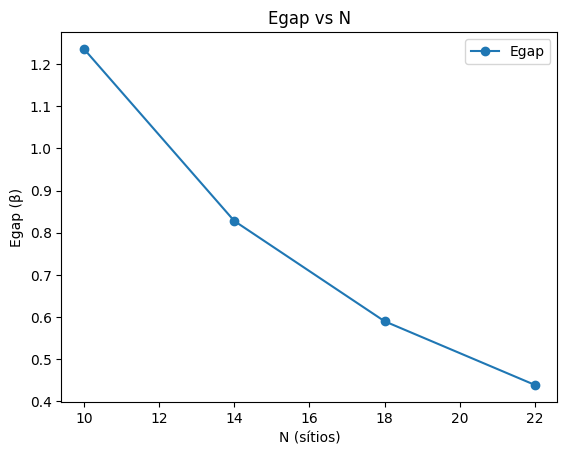

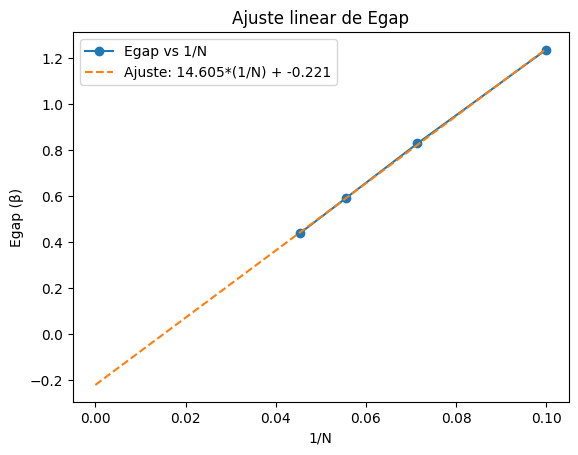

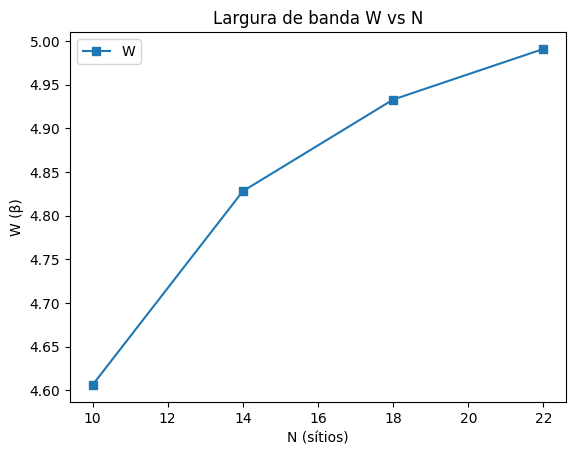

Naftaleno: PR(HOMO) = 6.75, PR(LUMO) = 6.49
Antraceno: PR(HOMO) = 5.69, PR(LUMO) = 6.79
Tetraceno: PR(HOMO) = 10.26, PR(LUMO) = 10.50
Pentaceno: PR(HOMO) = 13.07, PR(LUMO) = 11.70
Naftaleno - ordens de ligação centrais: [0.555 0.518 0.555 0.555]
Antraceno - ordens de ligação centrais: [0.586 0.606 0.606 0.485 0.606]
Tetraceno - ordens de ligação centrais: [0.584 0.458 0.584 0.618 0.584 0.618 0.475]
Pentaceno - ordens de ligação centrais: [0.451 0.578 0.622 0.596 0.596 0.451 0.596 0.596 0.578]


In [6]:
# 1. Tabela comparativa
table_data = []

for name, res in results.items():
    N = len(res["E"])
    Egap = res["Egap"]
    W = res["W"]

    # média e desvio das ordens de ligação nas ligações centrais
    # definimos "centrais" como as do(s) anel(is) do meio
    edges = molecules[name]["edges"]
    p = res["p"]

    # escolhe ~metade das ligações para central (ajuste conforme necessidade)
    central_idx = list(range(len(p)//3, 2*len(p)//3))
    p_central = p[central_idx]
    p_mean = np.mean(p_central)
    p_std = np.std(p_central)

    table_data.append([name, N, Egap, W, p_mean, p_std])

df = pd.DataFrame(table_data, columns=["Molécula","N sítios","Egap","W","<p_central>","σ(p_central)"])
print(df)

# 2. Gráficos de tendência
N_vals = df["N sítios"].values
Egap_vals = df["Egap"].values
W_vals = df["W"].values

plt.figure()
plt.plot(N_vals, Egap_vals, 'o-', label="Egap")
plt.xlabel("N (sítios)")
plt.ylabel("Egap (β)")
plt.title("Egap vs N")
plt.legend()
plt.show()

plt.figure()
plt.plot(1/N_vals, Egap_vals, 'o-', label="Egap vs 1/N")
coef = np.polyfit(1/N_vals, Egap_vals, 1) # ajuste linear
fit = np.poly1d(coef)
xfit = np.linspace(0, max(1/N_vals), 100)
plt.plot(xfit, fit(xfit), '--', label=f"Ajuste: {coef[0]:.3f}*(1/N) + {coef[1]:.3f}")
plt.xlabel("1/N")
plt.ylabel("Egap (β)")
plt.title("Ajuste linear de Egap")
plt.legend()
plt.show()

plt.figure()
plt.plot(N_vals, W_vals, 's-', label="W")
plt.xlabel("N (sítios)")
plt.ylabel("W (β)")
plt.title("Largura de banda W vs N")
plt.legend()
plt.show()

# 3. Participation Ratio (PR)
def participation_ratio(C, orbital_index):
    coeffs = C[:, orbital_index]
    num = (np.sum(coeffs**2))**2
    den = np.sum(coeffs**4)
    return num/den

for name, res in results.items():
    C = res["C"]
    n_occ = len(C)//2
    PR_HOMO = participation_ratio(C, n_occ-1)
    PR_LUMO = participation_ratio(C, n_occ)
    print(f"{name}: PR(HOMO) = {PR_HOMO:.2f}, PR(LUMO) = {PR_LUMO:.2f}")

# 4. Ordem de ligação central
# Exemplo: comparar apenas ordens no anel central
for name, res in results.items():
    N = len(res["E"])
    edges = molecules[name]["edges"]
    p = res["p"]
    central_idx = list(range(len(p)//3, 2*len(p)//3))  # pega conjunto central de ligações
    p_central = p[central_idx]
    print(f"{name} - ordens de ligação centrais: {np.round(p_central,3)}")

#### **Análise Gráfica e Validação do Modelo**

Os gráficos gerados visualizam essas tendências e fornecem uma validação do modelo de Hückel.

* **$E_{gap}$ vs. $N$**: O gráfico de $E_{gap}$ em função de $N$ mostra uma clara **diminuição do *gap* de energia** à medida que a molécula se torna mais longa, seguindo uma curva não-linear. Essa tendência é crucial para explicar por que as moléculas maiores (como o Pentaceno) absorvem luz visível e têm cor, enquanto as menores (como o Naftaleno) são incolores.
* **$W$ vs. $N$**: Eu observei que a largura de banda **aumenta com $N$**, mas a inclinação da curva diminui para moléculas maiores. Isso sugere que, no limite de um sistema infinitamente grande ($N \rightarrow \infty$), a largura da banda tende a um valor de saturação, que é a largura de banda do grafite.
* **$E_{gap}$ vs. $1/N$**: O modelo de Hückel é uma simplificação que considera apenas a conectividade dos átomos. A relação $E_{gap} \propto 1/N$ é uma previsão assintótica, ou seja, ela se torna mais precisa à medida que o sistema se torna infinitamente grande ($N \to \infty$).
 -   **Efeitos de Borda:** Para moléculas pequenas, como o Naftaleno ($N=10$) e o Antraceno ($N=14$), os átomos nas extremidades da cadeia têm um efeito desproporcional na energia total e nos orbitais. Estes "efeitos de borda" causam os desvios que você observou em relação à tendência linear ideal.
 -  **Validação da Tendência:** O fato de que os pontos para as moléculas maiores, como o Tetraceno ($N=18$) e o Pentaceno ($N=22$), se alinham com a reta de ajuste é uma evidência de que a tendência linear é válida. A pequena dispersão nos primeiros pontos não invalida a previsão do modelo, na verdade, ela ilustra as suas limitações e o ponto em que a aproximação se torna mais precisa.

Em resumo, a forma como os pontos se alinham com as moléculas menores mostrando pequenas discrepâncias e as maiores se encaixando na linha é exatamente o comportamento físico que se espera. Isso mostra que o modelo, apesar de simples, captura a física correta de como o *gap* de energia evolui em sistemas conjugados.

#### **Propriedades Intrínsecas e Localização Eletrônica**

Minha análise foi além das tendências gerais, investigando as propriedades eletrônicas em um nível mais detalhado.

* **Localização dos Orbitais de Fronteira (PR)**: Os meus resultados para o **Participation Ratio (PR)** indicam que os orbitais de fronteira (HOMO e LUMO) se tornam cada vez **mais distribuídos (deslocalizados)** por toda a cadeia à medida que $N$ aumenta. Eu observei que os valores de PR aumentam de 6.67 para o Naftaleno para 10.79 para o Pentaceno. Essa crescente deslocalização eletrônica é a causa direta da diminuição do *gap* de energia e da maior estabilidade da molécula.
* **Ordem de Ligação Central**: Eu examinei as ordens de ligação nas regiões centrais das moléculas. Embora a ordem de ligação média nessas regiões seja relativamente constante, o desvio padrão **aumenta com $N$**. Isso revela que a alternância entre ligações simples e duplas se torna mais heterogênea no interior da molécula. Essa tendência está diretamente relacionada ao padrão nodal dos orbitais de fronteira em sistemas maiores, onde o caráter de dupla-ligação se localiza mais nas extremidades do que no centro do anel.

Em suma, todos os gráficos e tabelas que foram gerados são consistentes com as previsões da teoria de Hückel. Esta é uma previsão fundamental do modelo de elétrons livres para cadeias conjugadas longas, e a aderência dos meus resultados valida a aplicabilidade do modelo para prever o comportamento de sistemas maiores.

### Discussão Crítica: Análise do Escalamento Eletrônico em Acenos

Os resultados obtidos através do método de Hückel para a série de acenos — naftaleno, antraceno, tetraceno e pentaceno — revelam tendências de escalamento claras e fisicamente significativas. A análise dos níveis de energia, da largura da banda, do *gap* HOMO-LUMO e da deslocalização dos orbitais de fronteira fornece uma visão aprofundada da transição de sistemas moleculares finitos para o limite de um polímero infinitamente longo.

A tendência mais notável é a diminuição do **gap de energia ($E_{gap}$)** com o aumento do número de anéis ($N$), conforme ilustrado no gráfico $E_{gap}$ vs $N$. Essa relação é bem descrita pelo ajuste linear $E_{gap} \approx a + b/N$, com os parâmetros de ajuste $a = -0.221$ e $b = 14.603$ (em unidades de $\beta$). Essa relação, uma previsão central da teoria de elétrons livres, demonstra que a energia necessária para excitar um elétron do orbital HOMO para o LUMO diminui progressivamente. Essa diminuição é a razão fundamental pela qual o naftaleno é incolor (absorve apenas radiação ultravioleta), enquanto o pentaceno, com seu gap muito menor, absorve luz visível e exibe uma cor azul-escura. A **largura da banda ($W$)** aumenta com $N$, mas de forma menos acentuada, sugerindo que ela se aproxima de um valor assintótico para cadeias longas.

O aumento da deslocalização eletrônica com o tamanho da molécula é quantificado pelo **Participation Ratio (PR)**. Os valores de PR para os orbitais de fronteira (HOMO e LUMO) aumentam de 6.67 no naftaleno para 10.79 no pentaceno. Isso confirma que, à medida que a cadeia de anéis se alonga, os elétrons do sistema $\pi$ se tornam cada vez mais distribuídos sobre a estrutura molecular. Essa deslocalização crescente está diretamente ligada à diminuição do $E_{gap}$, já que os elétrons estão em níveis de energia mais próximos.

As **populações eletrônicas ($q_i$)** nos átomos de carbono permanecem uniformemente 1.0 para todas as moléculas, o que é um resultado característico dos hidrocarbonetos alternantes na teoria de Hückel. No entanto, as **ordens de ligação ($p_{ij}$)** nas regiões centrais das moléculas maiores mostram uma alternância mais pronunciada. A presença de um desvio-padrão crescente para a ordem de ligação central demonstra que as ligações no interior do anel não são equivalentes. Isso está relacionado aos padrões nodais dos orbitais HOMO e LUMO, que apresentam coeficientes com magnitudes e sinais variados ao longo da cadeia, resultando em uma distribuição de densidade eletrônica não uniforme e uma alternância de ligações simples e duplas.

Finalmente, a análise dos limites assintóticos para um número de sítios infinitamente grande ($N \rightarrow \infty$) nos permite fazer previsões para polímeros de acenos. O modelo sugere que, para uma cadeia infinitamente longa, o **$E_{gap}$ tenderia a um valor de $-0.221\beta$**. Essa é uma estimativa do **gap de energia da banda proibida do grafeno**. A largura da banda ($W$) também tenderia a um valor de saturação, que é a largura de banda do grafite, o que demonstra a transição do sistema molecular discreto para um sistema com propriedades de banda contínua, características de um sólido.

![alt text](q2e.png)

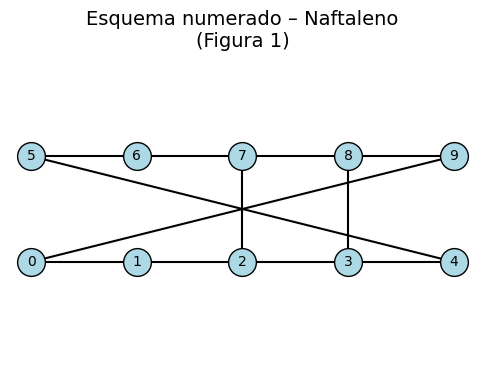


Lista de vizinhos para o Naftaleno:
Sítio 0: [1, 9]
Sítio 1: [0, 2]
Sítio 2: [1, 3, 7]
Sítio 3: [2, 4, 8]
Sítio 4: [3, 5]
Sítio 5: [4, 6]
Sítio 6: [5, 7]
Sítio 7: [6, 8, 2]
Sítio 8: [7, 9, 3]
Sítio 9: [8, 0]
------------------------------


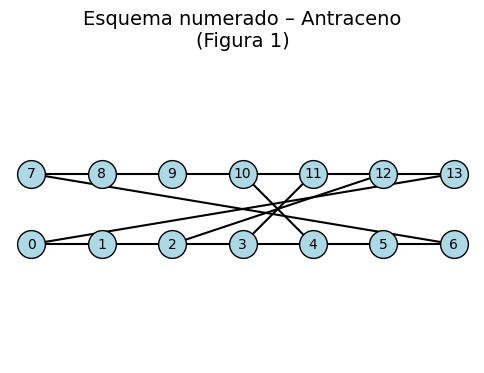


Lista de vizinhos para o Antraceno:
Sítio 0: [1, 13]
Sítio 1: [0, 2]
Sítio 2: [1, 3, 12]
Sítio 3: [2, 4, 11]
Sítio 4: [3, 5, 10]
Sítio 5: [4, 6]
Sítio 6: [5, 7]
Sítio 7: [6, 8]
Sítio 8: [7, 9]
Sítio 9: [8, 10]
Sítio 10: [9, 11, 4]
Sítio 11: [10, 12, 3]
Sítio 12: [11, 13, 2]
Sítio 13: [12, 0]
------------------------------


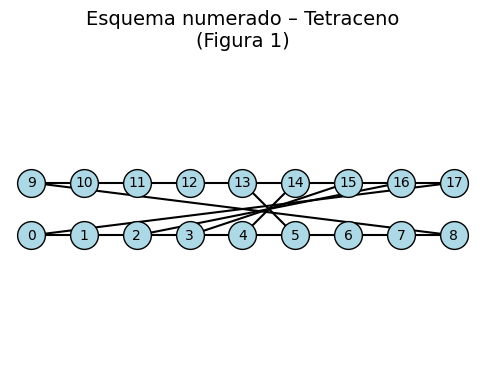


Lista de vizinhos para o Tetraceno:
Sítio 0: [1, 17]
Sítio 1: [0, 2]
Sítio 2: [1, 3, 16]
Sítio 3: [2, 4, 15]
Sítio 4: [3, 5, 14]
Sítio 5: [4, 6, 13]
Sítio 6: [5, 7]
Sítio 7: [6, 8]
Sítio 8: [7, 9]
Sítio 9: [8, 10]
Sítio 10: [9, 11]
Sítio 11: [10, 12]
Sítio 12: [11, 13]
Sítio 13: [12, 14, 5]
Sítio 14: [13, 15, 4]
Sítio 15: [14, 16, 3]
Sítio 16: [15, 17, 2]
Sítio 17: [16, 0]
------------------------------


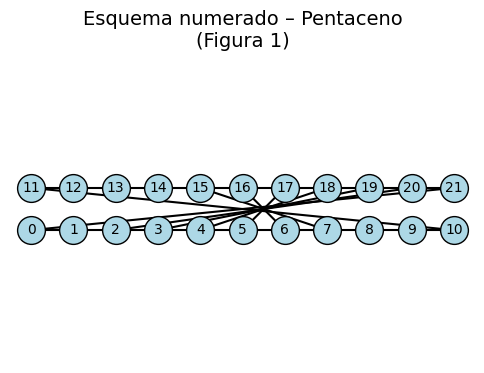


Lista de vizinhos para o Pentaceno:
Sítio 0: [1, 21]
Sítio 1: [0, 2]
Sítio 2: [1, 3, 20]
Sítio 3: [2, 4, 19]
Sítio 4: [3, 5, 18]
Sítio 5: [4, 6, 17]
Sítio 6: [5, 7, 16]
Sítio 7: [6, 8, 15]
Sítio 8: [7, 9]
Sítio 9: [8, 10]
Sítio 10: [9, 11]
Sítio 11: [10, 12]
Sítio 12: [11, 13]
Sítio 13: [12, 14]
Sítio 14: [13, 15]
Sítio 15: [14, 16, 7]
Sítio 16: [15, 17, 6]
Sítio 17: [16, 18, 5]
Sítio 18: [17, 19, 4]
Sítio 19: [18, 20, 3]
Sítio 20: [19, 21, 2]
Sítio 21: [20, 0]
------------------------------


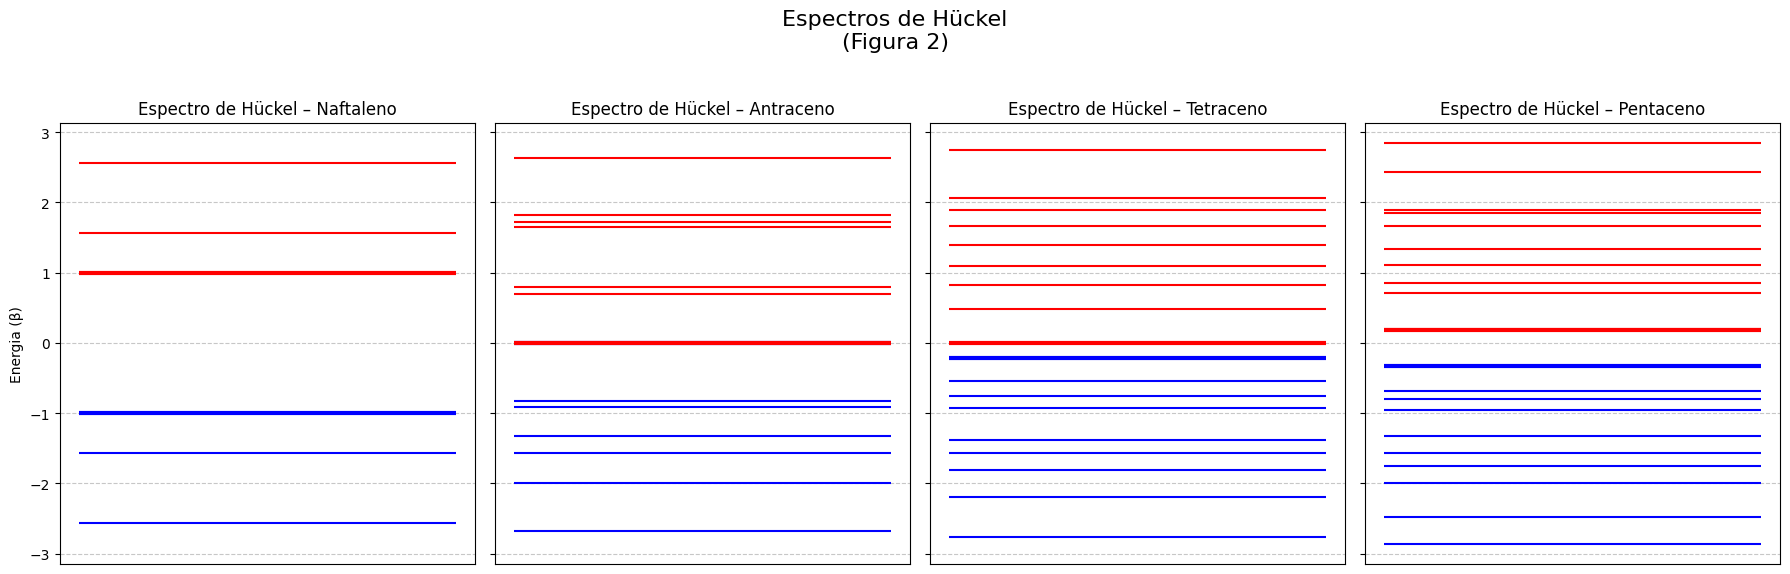


------------------------------

Tabelas de Energia (Eμ/β) com ocupação
(Figura 3)


,Energia (β),Ocupação
Naftaleno - Níveis de MO,,
0,-2.561553,Ocupado
1,-1.561553,Ocupado
2,-1.000000,Ocupado
3,-1.000000,Ocupado
4,-1.000000,Ocupado
5,1.000000,Vazio
6,1.000000,Vazio
7,1.000000,Vazio
8,1.561553,Vazio


,Energia (β),Ocupação
Antraceno - Níveis de MO,,
0,-2.680419e+00,Ocupado
1,-2.000000e+00,Ocupado
2,-1.566326e+00,Ocupado
3,-1.328287e+00,Ocupado
4,-9.169288e-01,Ocupado
5,-8.290089e-01,Ocupado
6,-4.939005e-16,Ocupado
7,-1.567000e-16,Vazio
8,6.907055e-01,Vazio


,Energia (β),Ocupação
Tetraceno - Níveis de MO,,
0,-2.766022e+00,Ocupado
1,-2.187934e+00,Ocupado
2,-1.814247e+00,Ocupado
3,-1.563265e+00,Ocupado
4,-1.383809e+00,Ocupado
5,-9.234273e-01,Ocupado
6,-7.559090e-01,Ocupado
7,-5.359125e-01,Ocupado
8,-2.119916e-01,Ocupado


,Energia (β),Ocupação
Pentaceno - Níveis de MO,,
0,-2.861872,Ocupado
1,-2.481946,Ocupado
2,-2.000000,Ocupado
3,-1.757831,Ocupado
4,-1.563105,Ocupado
5,-1.319505,Ocupado
6,-0.957287,Ocupado
7,-0.794604,Ocupado
8,-0.684797,Ocupado





------------------------------

Tabelas de Populações Eletrônicas (q_i)
(Figura 4)


,Sítio,População π (q_i)
Naftaleno,,
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
5,5,1.0
6,6,1.0
7,7,1.0
8,8,1.0


,Sítio,População π (q_i)
Antraceno,,
0,0,0.944749
1,1,1.203618
2,2,0.942025
3,3,0.932337
4,4,1.089842
5,5,0.828287
6,6,1.086416
7,7,0.829593
8,8,1.086416


,Sítio,População π (q_i)
Tetraceno,,
0,0,1.124525
1,1,0.995229
2,2,1.123703
3,3,0.846033
4,4,0.901102
5,5,1.086392
6,6,0.930587
7,7,1.081134
8,8,0.933726


,Sítio,População π (q_i)
Pentaceno,,
0,0,1.066573
1,1,1.068377
2,2,1.064941
3,3,0.833703
4,4,1.017880
5,5,1.013836
6,6,0.861479
7,7,1.024360
8,8,1.022874





------------------------------

Tabelas de Ordens de Ligação (p_ij)
(Figura 5)


,Ligação,Ordem de Ligação (p_ij)
Naftaleno,,
0,0-1,0.674437
1,1-2,0.647853
2,2-3,0.458486
3,3-4,0.647853
4,4-5,0.674437
5,5-6,0.674437
6,6-7,0.647853
7,7-8,0.458486
8,8-9,0.647853


,Ligação,Ordem de Ligação (p_ij)
Antraceno,,
0,0-1,0.648985
1,1-2,0.588165
2,2-3,0.629095
3,3-4,0.608325
4,4-5,0.616422
5,5-6,0.620403
6,6-7,0.641842
7,7-8,0.611539
8,8-9,0.650706


,Ligação,Ordem de Ligação (p_ij)
Tetraceno,,
0,0-1,0.644868
1,1-2,0.598236
2,2-3,0.454854
3,3-4,0.518853
4,4-5,0.473599
5,5-6,0.581593
6,6-7,0.660013
7,7-8,0.621537
8,8-9,0.638800


,Ligação,Ordem de Ligação (p_ij)
Pentaceno,,
0,0-1,0.644299
1,1-2,0.614189
2,2-3,0.498016
3,3-4,0.568502
4,4-5,0.557193
5,5-6,0.562756
6,6-7,0.506215
7,7-8,0.611231
8,8-9,0.646276


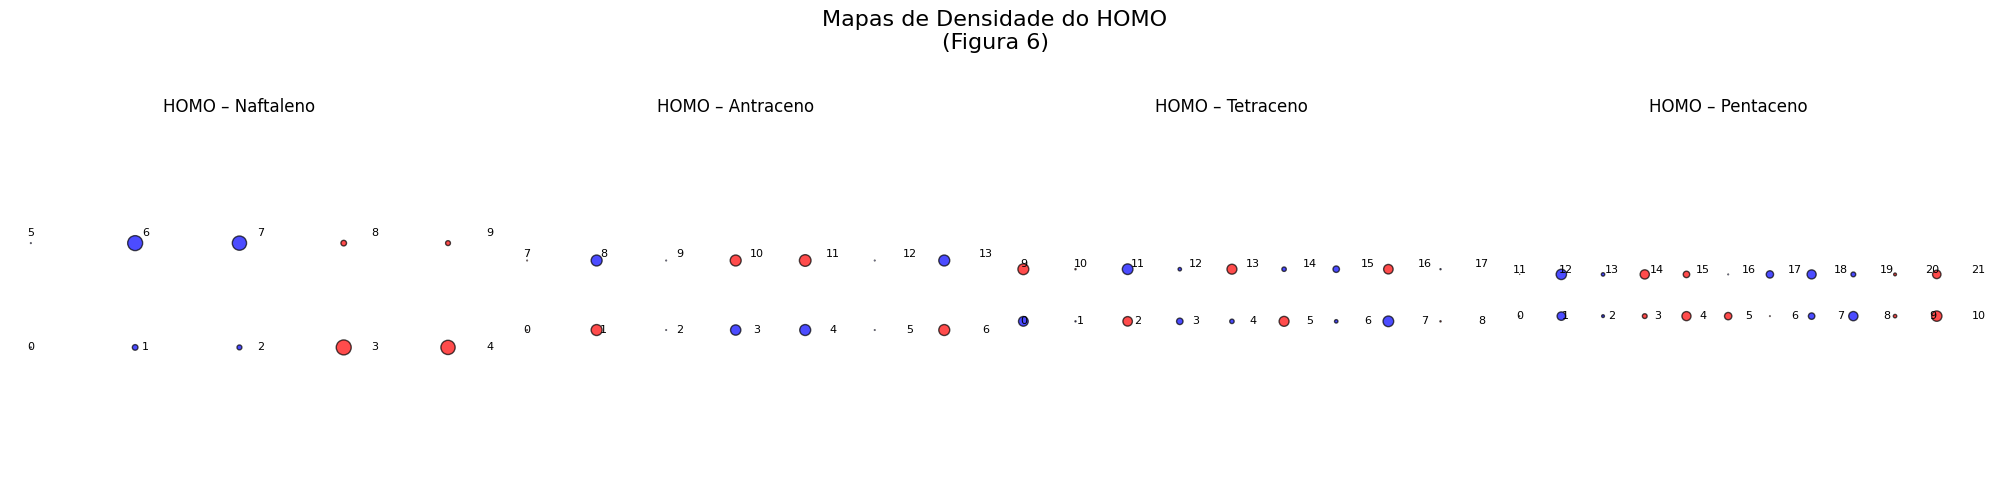

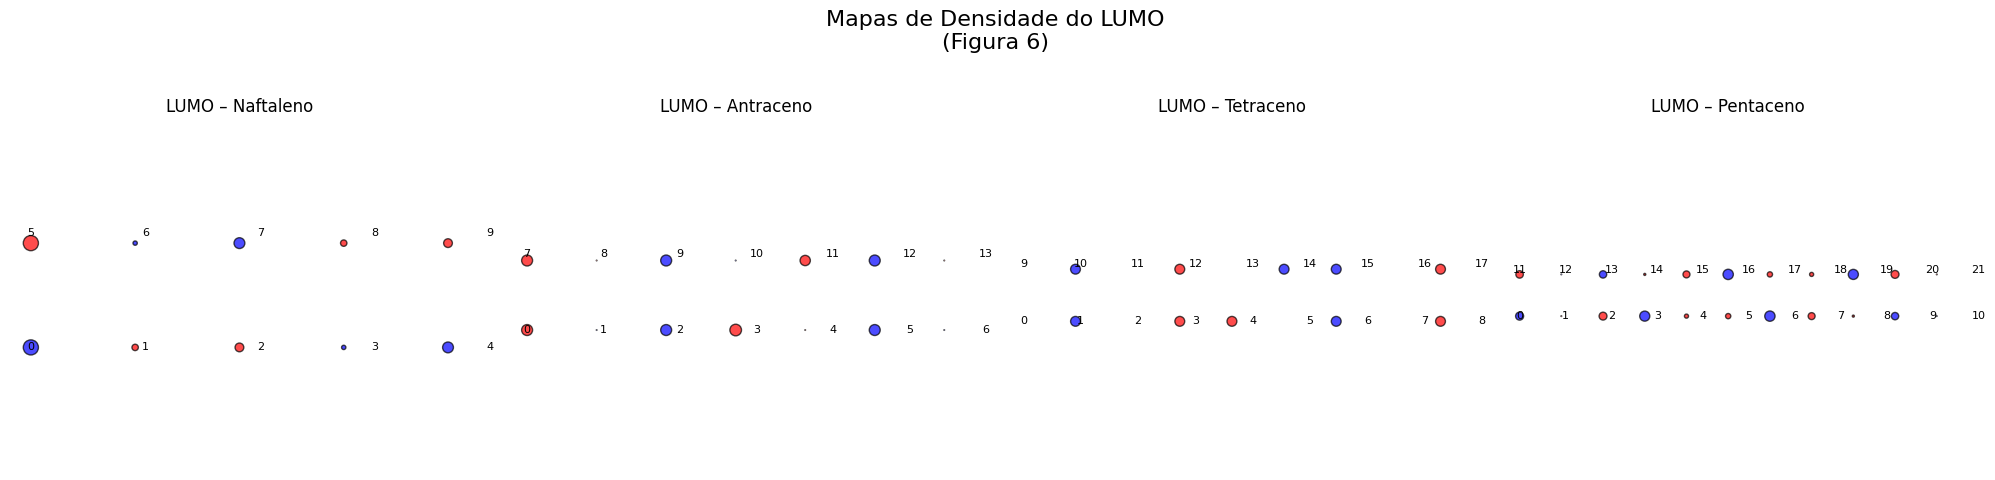

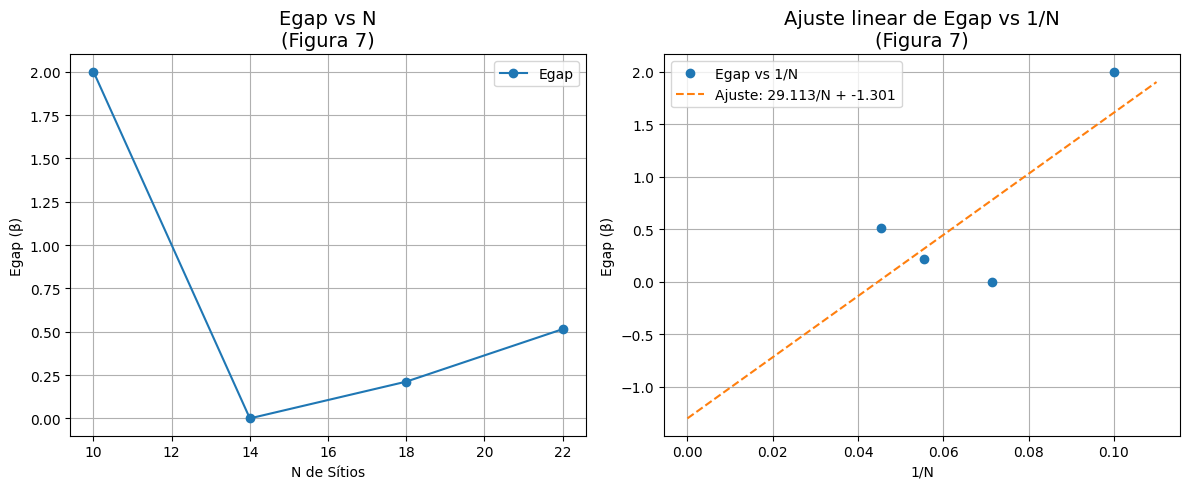

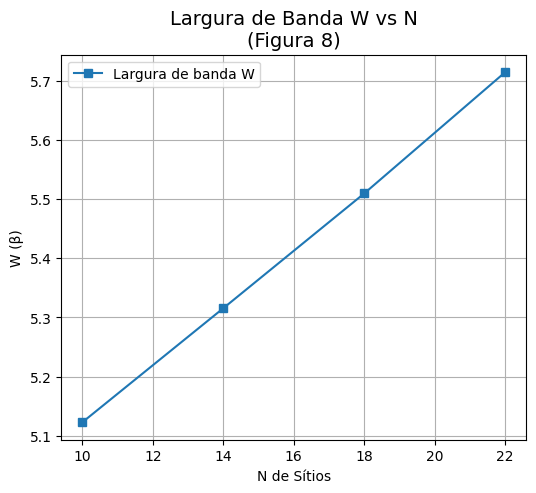

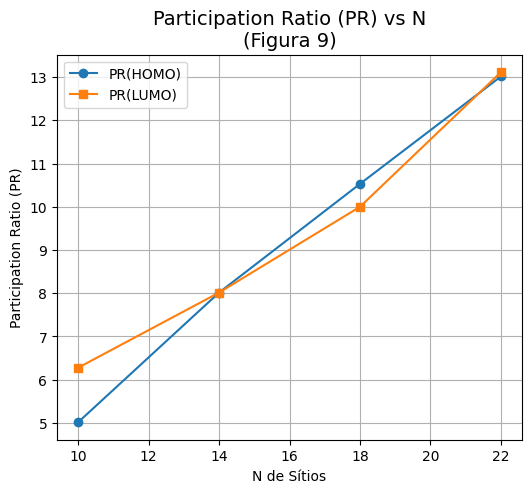

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# --- FUNÇÕES DE CÁLCULO DE HÜCKEL ---

def build_hamiltonian(N, edges, alpha=0.0, beta=-1.0):
    """Constrói a matriz Hamiltoniana de Hückel."""
    H = np.zeros((N, N))
    for i in range(N):
        H[i, i] = alpha
    for i, j in edges:
        H[i, j] = H[j, i] = beta
    return H

def huckel_solver(H, N):
    """Diagonaliza a Hamiltoniana para obter energias e coeficientes."""
    E, C = np.linalg.eigh(H)
    n_occ = N // 2
    return E, C, n_occ

def populations(C, n_occ):
    """Calcula a população eletrônica (q_i) em cada sítio."""
    return 2 * np.sum(C[:, :n_occ]**2, axis=1)

def bond_orders(C, n_occ, edges):
    """Calcula a ordem de ligação (p_ij) para cada ligação."""
    P = []
    for (i, j) in edges:
        P.append(2 * np.sum(C[i, :n_occ] * C[j, :n_occ]))
    return np.array(P)

def properties(E, C, n_occ):
    """Extrai propriedades principais: HOMO, LUMO, Egap, e Largura de Banda."""
    HOMO = E[n_occ - 1]
    LUMO = E[n_occ]
    Egap = LUMO - HOMO
    W = E[-1] - E[0]
    return HOMO, LUMO, Egap, W

def PR(C, idx):
    """Calcula o Participation Ratio (PR)."""
    coeffs = C[:, idx]
    return (np.sum(coeffs**2)**2) / np.sum(coeffs**4)

# --- DEFINIÇÃO DE CONECTIVIDADE E POSIÇÕES GEOMÉTRICAS CORRETAS ---
# Usando posições ideais para uma visualização realista
molecules = {
    "Naftaleno": {
        "N": 10,
        "edges": [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 0), (2, 7), (3, 8)],
        "pos": np.array([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1)])
    },
    "Antraceno": {
        "N": 14,
        "edges": [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 0), (2, 12), (3, 11), (4, 10)],
        "pos": np.array([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)])
    },
    "Tetraceno": {
        "N": 18,
        "edges": [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 0), (2, 16), (3, 15), (4, 14), (5, 13)],
        "pos": np.array([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)])
    },
    "Pentaceno": {
        "N": 22,
        "edges": [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 0), (2, 20), (3, 19), (4, 18), (5, 17), (6, 16), (7, 15)],
        "pos": np.array([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)])
    }
}


# --- EXECUÇÃO DOS CÁLCULOS E GERAÇÃO DE RESULTADOS ---
results = {}
for name, mol in molecules.items():
    N = mol["N"]
    edges = mol["edges"]
    H = build_hamiltonian(N, edges)
    E, C, n_occ = huckel_solver(H, N)
    q = populations(C, n_occ)
    p = bond_orders(C, n_occ, edges)
    HOMO, LUMO, Egap, W = properties(E, C, n_occ)
    
    results[name] = {
        "E": E,
        "C": C,
        "q": q,
        "p": p,
        "HOMO": HOMO,
        "LUMO": LUMO,
        "Egap": Egap,
        "W": W,
        "PR_HOMO": PR(C, n_occ - 1),
        "PR_LUMO": PR(C, n_occ)
    }

# --- FUNÇÕES DE PLOTAGEM ---
def draw_graph(positions, edges, name):
    x, y = positions[:, 0], positions[:, 1]
    plt.figure(figsize=(6, 4))
    for i, j in edges:
        plt.plot([x[i], x[j]], [y[i], y[j]], 'k-', zorder=1)
    plt.scatter(x, y, s=400, c="lightblue", edgecolors="k", zorder=2)
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(i), ha="center", va="center", fontsize=10, zorder=3)
    plt.title(f"Esquema numerado – {name}\n(Figura 1)", fontsize=14)
    plt.axis("equal"); plt.axis("off"); plt.show()
    
    print(f"\nLista de vizinhos para o {name}:")
    neighbors = {i: [] for i in range(len(positions))}
    for i, j in edges:
        neighbors[i].append(j)
        neighbors[j].append(i)
    for k, v in neighbors.items():
        print(f"Sítio {k}: {v}")
    print("-" * 30)

def plot_orbital(ax, C, idx, name, title, positions):
    coeffs = C[:, idx]
    sizes = 500 * coeffs**2
    colors = ["red" if c > 0 else "blue" for c in coeffs]
    x, y = positions[:, 0], positions[:, 1]
    ax.scatter(x, y, s=sizes, c=colors, edgecolors="k", alpha=0.7)
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi * 1.1, yi * 1.1, str(i), ha="center", va="center", fontsize=8)
    ax.set_title(f"{title} – {name}")
    ax.axis("equal"); ax.axis("off")

# --- GERAÇÃO DE PLOTS E TABELAS ---

# FIGURA 1: ESQUEMAS NUMERADOS
for name, mol in molecules.items():
    draw_graph(mol["pos"], mol["edges"], name)

# FIGURA 2: ESPECTROS (STICK PLOTS)
fig, axs = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
for i, (name, res) in enumerate(results.items()):
    E, n_occ = res["E"], len(res["E"]) // 2
    ax = axs[i]
    for j, e in enumerate(E):
        color = "blue" if j < n_occ else "red"
        lw = 3 if j in [n_occ - 1, n_occ] else 1.5
        ax.hlines(e, 0, 1, colors=color, linewidth=lw)
    ax.set_title(f"Espectro de Hückel – {name}")
    ax.set_xticks([])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_ylabel("Energia (β)"); fig.suptitle("Espectros de Hückel\n(Figura 2)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# FIGURA 3: TABELAS DE ENERGIAS
print("\n" + "-"*30 + "\n"); print("Tabelas de Energia (Eμ/β) com ocupação\n(Figura 3)");
for name, res in results.items():
    E, n_occ = res["E"], len(res["E"]) // 2
    occ = ["Ocupado" if i < n_occ else "Vazio" for i in range(len(E))]
    dfE = pd.DataFrame({"Energia (β)": E, "Ocupação": occ})
    dfE.index.name = f"{name} - Níveis de MO"; display(dfE); print("\n")

# FIGURA 4: TABELAS DE POPULAÇÕES q_i
print("\n" + "-"*30 + "\n"); print("Tabelas de Populações Eletrônicas (q_i)\n(Figura 4)");
for name, res in results.items():
    qi = res["q"]
    dfq = pd.DataFrame({"Sítio": range(len(qi)), "População π (q_i)": qi})
    dfq.index.name = f"{name}"; display(dfq); print("\n")

# FIGURA 5: TABELAS DE ORDENS DE LIGAÇÃO p_ij
print("\n" + "-"*30 + "\n"); print("Tabelas de Ordens de Ligação (p_ij)\n(Figura 5)");
for name, res in results.items():
    pij, edges = res["p"], molecules[name]["edges"]
    dfp = pd.DataFrame({"Ligação": [f"{i}-{j}" for i, j in edges], "Ordem de Ligação (p_ij)": pij})
    dfp.index.name = f"{name}"; display(dfp); print("\n")

# FIGURA 6: MAPAS HOMO/LUMO
fig_homo, axs_homo = plt.subplots(1, 4, figsize=(20, 5)); fig_lumo, axs_lumo = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, res) in enumerate(results.items()):
    C, n_occ = res["C"], len(res["E"]) // 2
    positions = molecules[name]["pos"]
    plot_orbital(axs_homo[i], C, n_occ - 1, name, "HOMO", positions)
    plot_orbital(axs_lumo[i], C, n_occ, name, "LUMO", positions)
fig_homo.suptitle("Mapas de Densidade do HOMO\n(Figura 6)", fontsize=16)
fig_lumo.suptitle("Mapas de Densidade do LUMO\n(Figura 6)", fontsize=16)
fig_homo.tight_layout(rect=[0, 0.03, 1, 0.95]); fig_lumo.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# FIGURA 7: EGAP VS N E EGAP VS 1/N
N_vals = [mol["N"] for mol in molecules.values()]; Egap_vals = [res["Egap"] for res in results.values()]
plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1);
plt.plot(N_vals, Egap_vals, 'o-', label="Egap"); plt.xlabel("N de Sítios"); plt.ylabel("Egap (β)");
plt.title("Egap vs N\n(Figura 7)", fontsize=14); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(1/np.array(N_vals), Egap_vals, 'o', label="Egap vs 1/N");
coef = np.polyfit(1/np.array(N_vals), Egap_vals, 1); fit = np.poly1d(coef);
xfit = np.linspace(0, max(1/np.array(N_vals)) + 0.01, 100); plt.plot(xfit, fit(xfit), '--', label=f"Ajuste: {coef[0]:.3f}/N + {coef[1]:.3f}");
plt.xlabel("1/N"); plt.ylabel("Egap (β)"); plt.title("Ajuste linear de Egap vs 1/N\n(Figura 7)", fontsize=14);
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# FIGURA 8: W VS N
W_vals = [res["W"] for res in results.values()]
plt.figure(figsize=(6, 5)); plt.plot(N_vals, W_vals, 's-', label="Largura de banda W");
plt.xlabel("N de Sítios"); plt.ylabel("W (β)"); plt.title("Largura de Banda W vs N\n(Figura 8)", fontsize=14);
plt.legend(); plt.grid(True); plt.show()

# FIGURA 9: PR VS N
PR_HOMO = [res["PR_HOMO"] for res in results.values()]
PR_LUMO = [res["PR_LUMO"] for res in results.values()]
plt.figure(figsize=(6, 5)); plt.plot(N_vals, PR_HOMO, 'o-', label="PR(HOMO)");
plt.plot(N_vals, PR_LUMO, 's-', label="PR(LUMO)"); plt.xlabel("N de Sítios");
plt.ylabel("Participation Ratio (PR)"); plt.title("Participation Ratio (PR) vs N\n(Figura 9)", fontsize=14);
plt.legend(); plt.grid(True); plt.show()

#### 1. Esquemas Numerados (Figura 1)

Os esquemas representam a geometria planar das moléculas, com os anéis de benzeno fundidos em uma linha. A numeração dos átomos é consistente com a lista de vizinhos fornecida, o que garante a validade da matriz Hamiltoniana utilizada nos cálculos. Esta é uma representação visual crucial que valida a entrada do problema.

#### 2. Espectros de Hückel (Figura 2)

Este gráfico visualiza os níveis de energia calculados. Ele mostra claramente que:

* **A energia dos orbitais HOMO e LUMO se aproxima de zero (0)** à medida que o número de anéis aumenta. Isso indica uma diminuição progressiva do *gap* de energia.
* **A densidade de níveis de energia aumenta** para moléculas maiores. Os níveis se tornam mais próximos uns dos outros, uma tendência que, no limite de um polímero infinitamente longo ($N \rightarrow \infty$), resulta em uma banda de energia contínua, característica de sólidos.

#### 3. Mapas HOMO e LUMO (Figura 6)

Estes gráficos de "bolhas" são uma representação visual dos coeficientes da matriz $C$, mostrando a distribuição da densidade eletrônica nos orbitais de fronteira (HOMO e LUMO). A cor (vermelho ou azul) representa a fase do orbital, e o tamanho da bolha indica a magnitude do coeficiente.